In [2]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(4)

In [3]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage, MolsToGridImage
from IPython.display import SVG, display, clear_output
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import sys
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [4]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


## Select one set of settings to test
(use the test_similiarity.py script to do the full set of experiments)

In [14]:
class_ = 1
similarity_metric = DataStructs.BulkTanimotoSimilarity # BulkDiceSimilarity or BulkTanimotoSimilarity
similarity_label = 'Tanimoto'
getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=False)
getfp_label = 'Morgan2noFeat'
dataset = 'val'
label = '{}_class{}_fp{}_sim{}'.format(
    dataset,
    class_,
    getfp_label,
    similarity_label,
)

### Only get new FPs if necessary - is a little slow

In [15]:
try:
    if prev_FP != getfp:
        raise NameError
except NameError:
    all_fps = []
    for smi in tqdm(data['prod_smiles']):
        all_fps.append(getfp(smi))
    data['prod_fp'] = all_fps
    prev_FP = getfp

100%|██████████| 50016/50016 [00:37<00:00, 1343.35it/s]


### Get the training data subset of the full data

In [16]:
if class_ != 'all':
    datasub = data.loc[data['class'] == class_].loc[data['dataset'] == 'train']
    datasub_val = data.loc[data['class'] == class_].loc[data['dataset'] == dataset]
else:
    datasub = data.loc[data['dataset'] == 'train']
    datasub_val = data.loc[data['dataset'] == dataset]
fps = list(datasub['prod_fp'])
print('Size of knowledge base: {}'.format(len(fps)))

Size of knowledge base: 12120


## Go through full validation/test data, define the function for processing

In [27]:
jx_cache = {}
draw = False
debug = False

def do_one(ix, draw=draw, debug=debug, max_prec=100):
    
    rec_for_printing = ''
    
    ex = Chem.MolFromSmiles(datasub_val['prod_smiles'][ix])
    rct = rdchiralReactants(datasub_val['prod_smiles'][ix])
    if draw: 
        print('Mol {}'.format(ix))
    if debug:
        rec_for_printing += datasub_val['prod_smiles'][ix] + '\n'
        rec_for_printing += 'True reaction:'
        rec_for_printing += datasub_val['rxn_smiles'][ix] + '\n'
    fp = datasub_val['prod_fp'][ix]
    
    sims = similarity_metric(fp, [fp_ for fp_ in datasub['prod_fp']])
    js = np.argsort(sims)[::-1]

    if draw: display(ReactionStringToImage(datasub_val['rxn_smiles'][ix]))
    
    prec_goal = Chem.MolFromSmiles(datasub_val['rxn_smiles'][ix].split('>')[0])
    [a.ClearProp('molAtomMapNumber') for a in prec_goal.GetAtoms()]
    prec_goal = Chem.MolToSmiles(prec_goal, True)
    
    # Sometimes stereochem takes another canonicalization...
    prec_goal = Chem.MolToSmiles(Chem.MolFromSmiles(prec_goal), True)
    if debug:
        rec_for_printing += 'prec_goal: {}\n'.format(prec_goal)
    # Get probability of precursors
    probs = {}
    
    for ji, j in enumerate(js[:max_prec]):
        jx = datasub.index[j]
        
        if draw:
            print('\n\n' + '-'*50 + '\n')
            print('RANK {} PRECEDENT'.format(ji+1))
            print('PRODUCT MATCH SCORE: {}'.format(sims[j]))
            display(ReactionStringToImage(datasub['rxn_smiles'][jx]))
        if debug:
            rec_for_printing += '\nReaction precedent {}, prod similarity {}\n'.format(
                ji+1, sims[j])
            rec_for_printing += '-> rxn_smiles {}\n'.format(datasub['rxn_smiles'][jx])
        if jx in jx_cache:
            (rxn, template, rcts_ref_fp) = jx_cache[jx]
        else:
            template = '(' + process_an_example(datasub['rxn_smiles'][jx], super_general=True).replace('>>', ')>>')
            rcts_ref_fp = getfp(datasub['rxn_smiles'][jx].split('>')[0])
            rxn = rdchiralReaction(template)
            jx_cache[jx] = (rxn, template, rcts_ref_fp)
        if debug:
            rec_for_printing += '-> template: {}\n'.format(template)
        if draw:
            print('-> template: {}'.format(template))
            
        try:
            outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
        except Exception as e:
            print(e)
            outcomes = []

        if not outcomes and draw:
            print('No precursors could be generated!')
            
        for precursors in outcomes:
            precursors_fp = getfp(precursors)
            precursors_sim = similarity_metric(precursors_fp, [rcts_ref_fp])[0]
            if debug:
                rec_for_printing += 'prec sim {} smiles {}\n'.format(precursors_sim, precursors)
            if draw:
                print('Precursor similarity {}, overall {}, smiles {}'.format(
                    precursors_sim, precursors_sim*sims[j], precursors))
                display(MolToImage(Chem.MolFromSmiles(precursors)))
            if precursors in probs:
                probs[precursors] = max(probs[precursors], precursors_sim * sims[j])
            else:
                probs[precursors] = precursors_sim * sims[j]
    
    testlimit = 50
    mols = []
    legends = []

    found_rank = 9999
    for r, (prec, prob) in enumerate(sorted(probs.iteritems(), key=lambda x:x[1], reverse=True)[:testlimit]):
        mols.append(Chem.MolFromSmiles(prec))
        if prec == prec_goal:
            found_rank = r + 1
            legends.append('[TRUE] {}'.format(prob))
        else:
            legends.append('{}'.format(prob))
            pass
    if found_rank == 9999 and debug:
        print(datasub_val['rxn_smiles'][ix])
        display(ReactionStringToImage(datasub_val['rxn_smiles'][ix]))
        print(prec_goal)
        draw = True
    
    if draw: 
        img=MolsToGridImage(mols[:9],molsPerRow=3,subImgSize=(300,300),legends=legends[:9])
        display(img)
        for mol in mols[:9]:
            print(Chem.MolToSmiles(mol, True))
    if debug:
        print(rec_for_printing)
    if draw or debug:
        raw_input('pause')
        clear_output()
        
    return found_rank

### Code for running one-at-a-time on a single core

In [ ]:
found_at_rank = []
found_at_rank_counter = defaultdict(int)

for ii, ix in enumerate(datasub_val.index):
        
    if ii % 1 == 0 and ii > 0:
        print('{} done'.format(ii))
        print('Current found_at_rank: {}'.format(found_at_rank_counter))
        
    found_rank = do_one(ix)
    found_at_rank.append(found_rank)
    found_at_rank_counter[found_rank] += 1

### Code to run in parallel

In [12]:
# Parallel
inputs = list(datasub_val.index)
found_at_rank = Parallel(n_jobs=num_cores, verbose=5)(delayed(do_one)(i) for i in inputs)

[Parallel(n_jobs=32)]: Done  18 out of  67 | elapsed:    8.4s remaining:   23.0s
[Parallel(n_jobs=32)]: Done  32 out of  67 | elapsed:   11.9s remaining:   13.1s
[Parallel(n_jobs=32)]: Done  46 out of  67 | elapsed:   14.9s remaining:    6.8s
[Parallel(n_jobs=32)]: Done  60 out of  67 | elapsed:   16.0s remaining:    1.9s
[Parallel(n_jobs=32)]: Done  67 out of  67 | elapsed:   17.5s finished


### Evaluate

In [13]:
# Evaluate
def ranks_to_acc(found_at_rank, fid=None):
    def fprint(txt):
        print(txt)
        if fid is not None:
            fid.write(txt + '\n')
            
    tot = float(len(found_at_rank))
    fprint('{:>8} \t {:>8}'.format('top-n', 'accuracy'))
    accs = []
    for n in [1, 3, 5, 10, 20, 50]:
        accs.append(sum([r <= n for r in found_at_rank]) / tot)
        fprint('{:>8} \t {:>8}'.format(n, accs[-1]))
    return accs

accs = ranks_to_acc(found_at_rank)

   top-n 	 accuracy
       1 	 0.955223880597
       3 	      1.0
       5 	      1.0
      10 	      1.0
      20 	      1.0
      50 	      1.0


## Example

Mol 40176


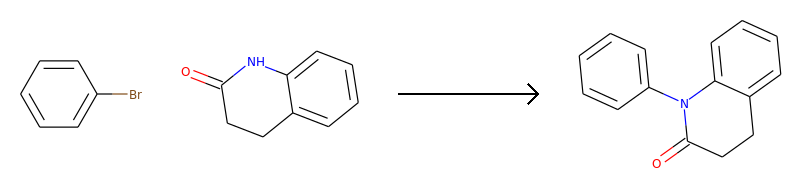



--------------------------------------------------

RANK 1 PRECEDENT
PRODUCT MATCH SCORE: 0.561643835616


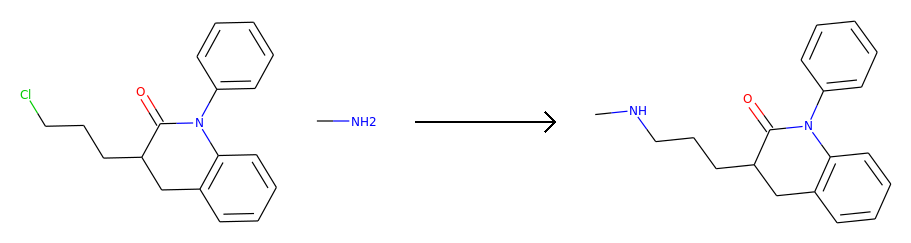

-> template: ([CH2;+0:1]-[NH;+0:2])>>Cl-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 2 PRECEDENT
PRODUCT MATCH SCORE: 0.528571428571


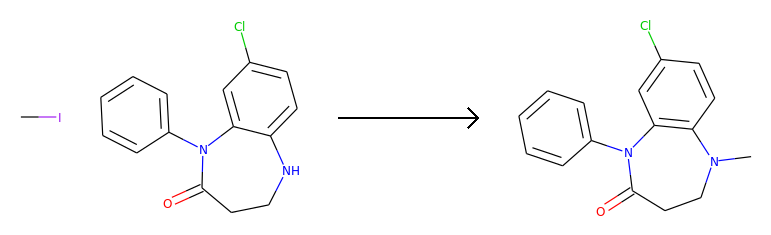

-> template: ([CH3;+0:1]-[N;H0;+0:2])>>I-[CH3;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 3 PRECEDENT
PRODUCT MATCH SCORE: 0.466666666667


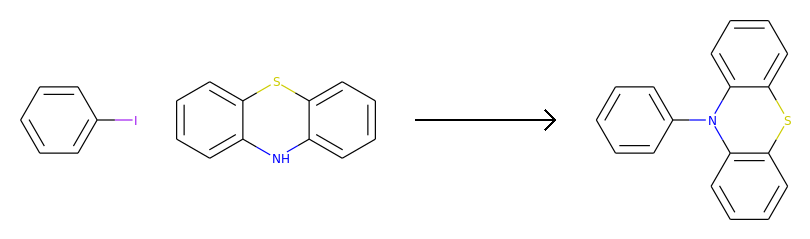

-> template: ([N;H0;+0:1]-[c;H0;+0:2])>>I-[c;H0;+0:2].[NH;+0:1]
Precursor similarity 0.325581395349, overall 0.151937984496, smiles O=C(CCc1ccccc1I)Nc1ccccc1


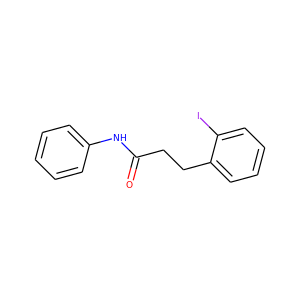

Precursor similarity 0.480519480519, overall 0.224242424242, smiles Ic1ccccc1.O=C1CCc2ccccc2N1


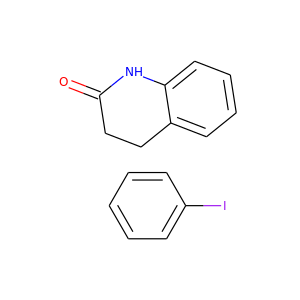



--------------------------------------------------

RANK 4 PRECEDENT
PRODUCT MATCH SCORE: 0.457142857143


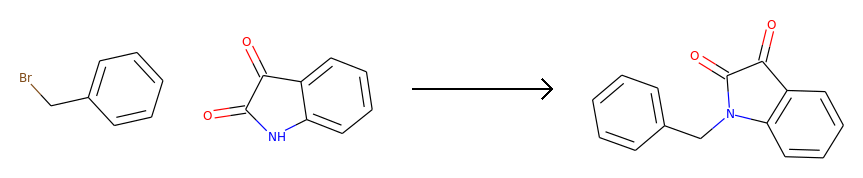

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Br-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 5 PRECEDENT
PRODUCT MATCH SCORE: 0.457142857143


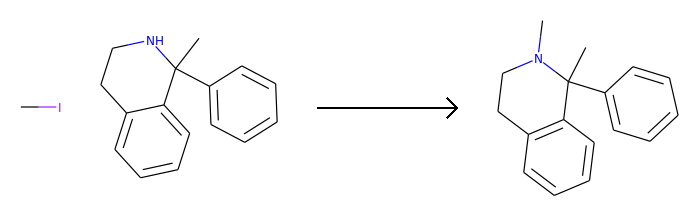

-> template: ([CH3;+0:1]-[N;H0;+0:2])>>I-[CH3;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 6 PRECEDENT
PRODUCT MATCH SCORE: 0.453333333333


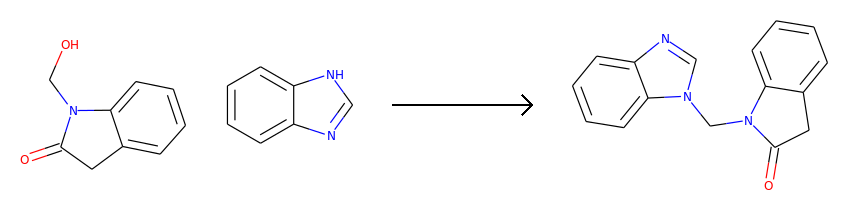

-> template: ([CH2;+0:1]-[n;H0;+0:2])>>O-[CH2;+0:1].[nH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 7 PRECEDENT
PRODUCT MATCH SCORE: 0.414285714286


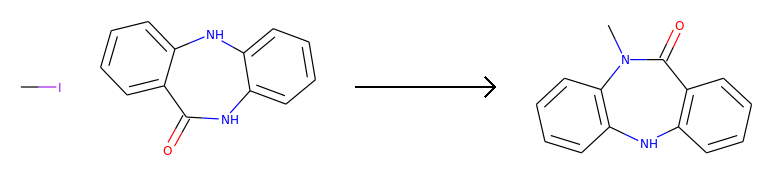

-> template: ([CH3;+0:1]-[N;H0;+0:2])>>I-[CH3;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 8 PRECEDENT
PRODUCT MATCH SCORE: 0.4125


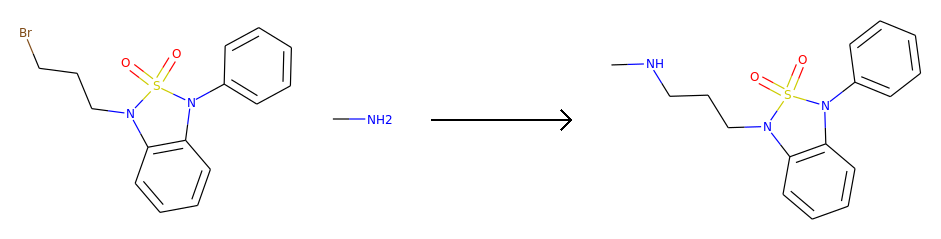

-> template: ([CH2;+0:1]-[NH;+0:2])>>Br-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 9 PRECEDENT
PRODUCT MATCH SCORE: 0.411111111111


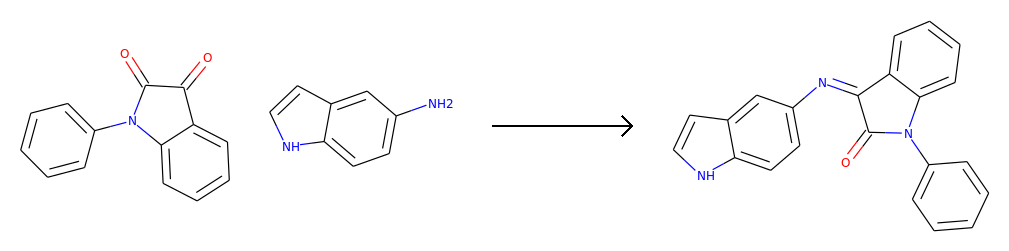

-> template: ([C;H0;+0:1]=[N;H0;+0:2])>>O=[C;H0;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 10 PRECEDENT
PRODUCT MATCH SCORE: 0.409090909091


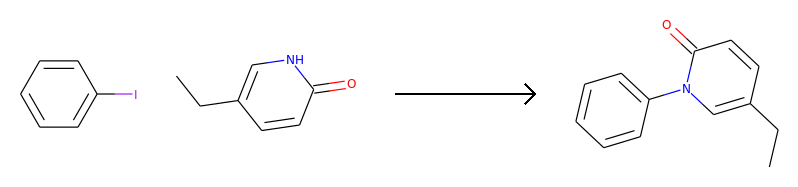

-> template: ([c;H0;+0:1]-[n;H0;+0:2])>>I-[c;H0;+0:1].[nH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 11 PRECEDENT
PRODUCT MATCH SCORE: 0.408450704225


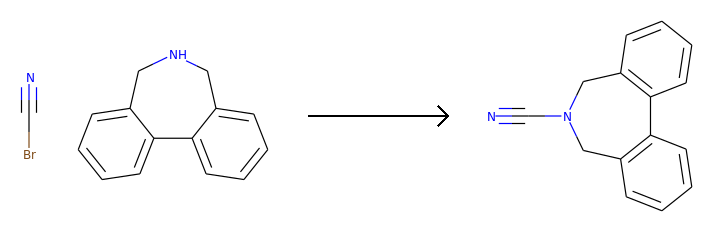

-> template: ([C;H0;+0:1]-[N;H0;+0:2])>>Br-[C;H0;+0:1].[NH;+0:2]
Precursor similarity 0.303797468354, overall 0.124086289891, smiles O=C(Br)CCc1ccccc1Nc1ccccc1


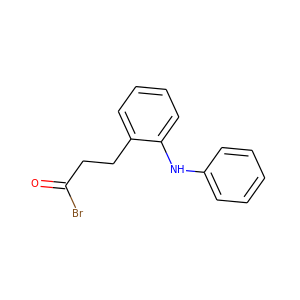



--------------------------------------------------

RANK 12 PRECEDENT
PRODUCT MATCH SCORE: 0.407894736842


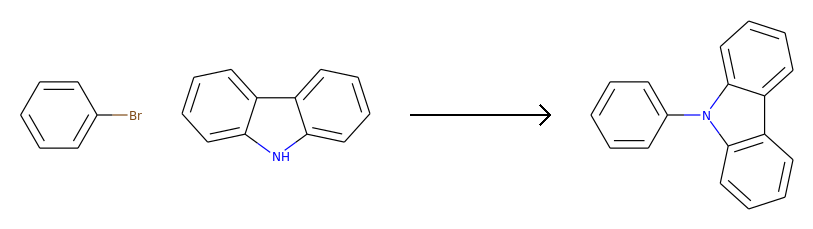

-> template: ([c;H0;+0:1]-[n;H0;+0:2])>>Br-[c;H0;+0:1].[nH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 13 PRECEDENT
PRODUCT MATCH SCORE: 0.402985074627


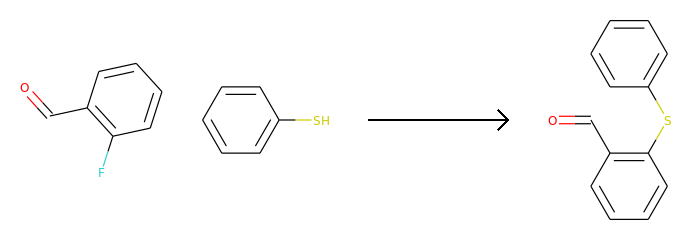

-> template: ([S;H0;+0:1]-[c;H0;+0:2])>>F-[c;H0;+0:2].[SH;+0:1]
No precursors could be generated!


--------------------------------------------------

RANK 14 PRECEDENT
PRODUCT MATCH SCORE: 0.4


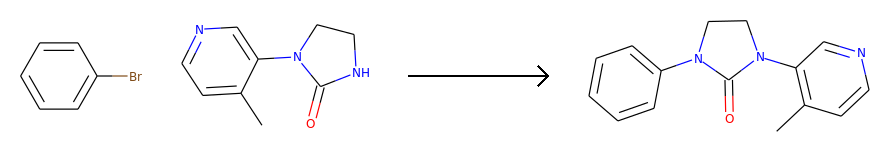

-> template: ([N;H0;+0:1]-[c;H0;+0:2])>>Br-[c;H0;+0:2].[NH;+0:1]
Precursor similarity 0.415584415584, overall 0.166233766234, smiles Brc1ccccc1.O=C1CCc2ccccc2N1


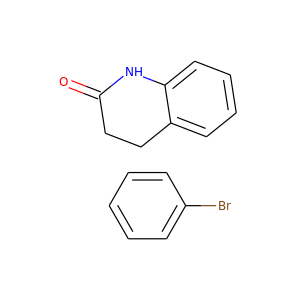

Precursor similarity 0.267441860465, overall 0.106976744186, smiles O=C(CCc1ccccc1Br)Nc1ccccc1


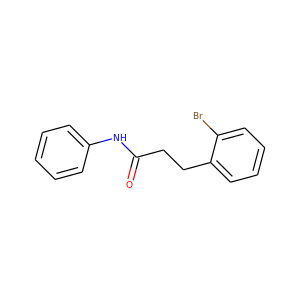



--------------------------------------------------

RANK 15 PRECEDENT
PRODUCT MATCH SCORE: 0.397727272727


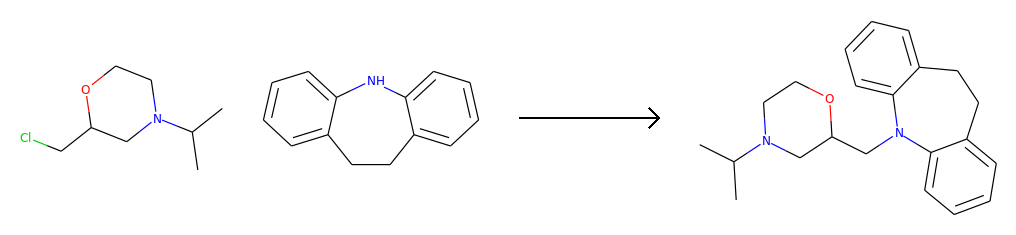

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Cl-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 16 PRECEDENT
PRODUCT MATCH SCORE: 0.397727272727


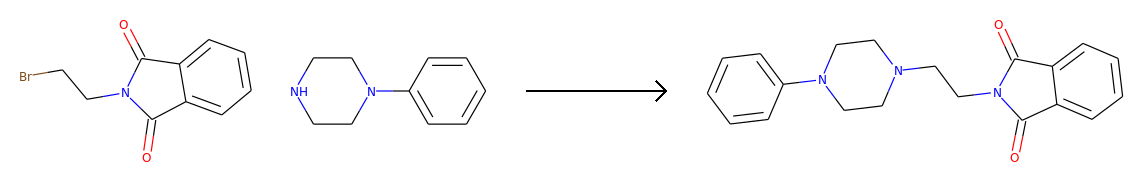

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Br-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 17 PRECEDENT
PRODUCT MATCH SCORE: 0.397590361446


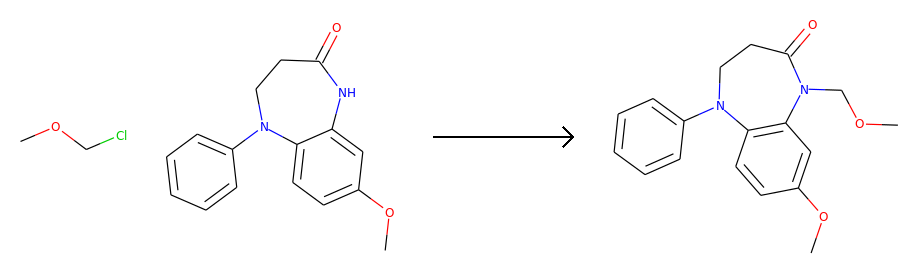

-> template: ([CH2;+0:1]-[N;H0;+0:2])>>Cl-[CH2;+0:1].[NH;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 18 PRECEDENT
PRODUCT MATCH SCORE: 0.397590361446


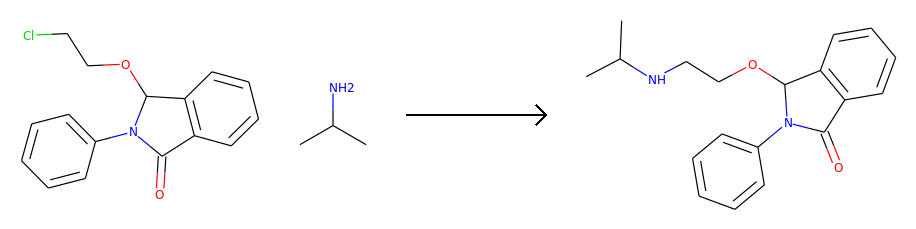

-> template: ([CH2;+0:1]-[NH;+0:2])>>Cl-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 19 PRECEDENT
PRODUCT MATCH SCORE: 0.397590361446


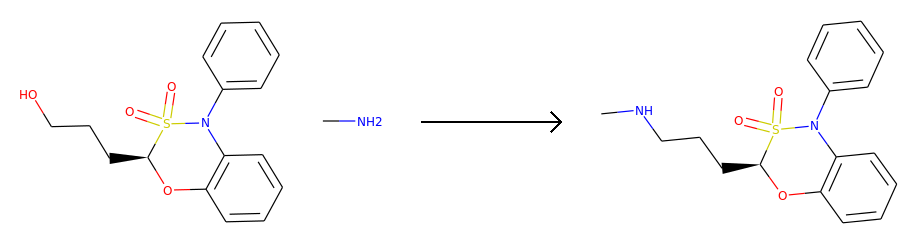

-> template: ([CH2;+0:1]-[NH;+0:2])>>O-[CH2;+0:1].[NH2;+0:2]
No precursors could be generated!


--------------------------------------------------

RANK 20 PRECEDENT
PRODUCT MATCH SCORE: 0.397435897436


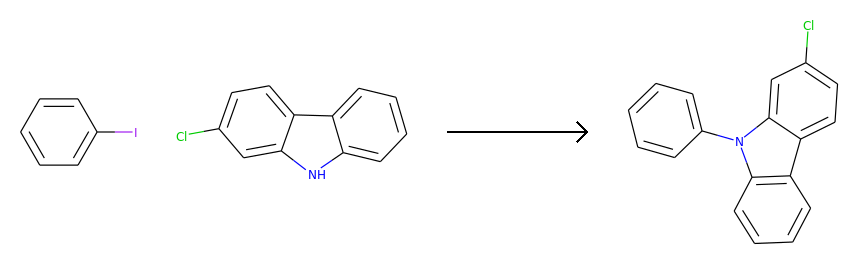

-> template: ([c;H0;+0:1]-[n;H0;+0:2])>>I-[c;H0;+0:1].[nH;+0:2]
No precursors could be generated!


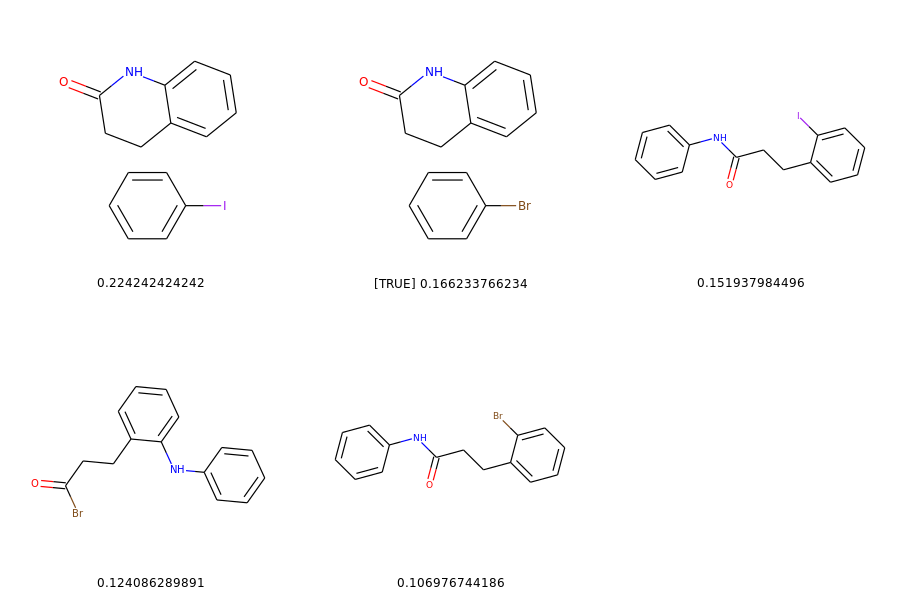

Ic1ccccc1.O=C1CCc2ccccc2N1
Brc1ccccc1.O=C1CCc2ccccc2N1
O=C(CCc1ccccc1I)Nc1ccccc1
O=C(Br)CCc1ccccc1Nc1ccccc1
O=C(CCc1ccccc1Br)Nc1ccccc1
O=C1CCc2ccccc2N1c1ccccc1
True reaction:Br[c:1]1[cH:2][cH:3][cH:4][cH:5][cH:6]1.[O:7]=[C:8]1[CH2:9][CH2:10][c:11]2[cH:12][cH:13][cH:14][cH:15][c:16]2[NH:17]1>>[c:1]1([N:17]2[C:8](=[O:7])[CH2:9][CH2:10][c:11]3[cH:12][cH:13][cH:14][cH:15][c:16]32)[cH:2][cH:3][cH:4][cH:5][cH:6]1
prec_goal: Brc1ccccc1.O=C1CCc2ccccc2N1

Reaction precedent 1, prod similarity 0.561643835616
-> rxn_smiles Cl[CH2:1][CH2:2][CH2:3][CH:4]1[C:5](=[O:6])[N:7]([c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:14]2[c:15]([cH:16][cH:17][cH:18][cH:19]2)[CH2:20]1.[CH3:21][NH2:22]>>[CH2:1]([CH2:2][CH2:3][CH:4]1[C:5](=[O:6])[N:7]([c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:14]2[c:15]([cH:16][cH:17][cH:18][cH:19]2)[CH2:20]1)[NH:22][CH3:21]
-> template: ([CH2;+0:1]-[NH;+0:2])>>Cl-[CH2;+0:1].[NH2;+0:2]

Reaction precedent 2, prod similarity 0.528571428571
-> rxn_smiles I[CH3:1].[O:2]=[C:3]1[CH2:4][

KeyboardInterrupt: 

In [28]:
inputs = list(datasub_val.index)
do_one(inputs[32], debug=True, draw=True, max_prec=20)